In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ruta = '/content/drive/My Drive/PPS COLAB'
sys.path.append(ruta)

import tensorflow as tf
from tensorflow import keras as ks
import matplotlib.pyplot as plt
import numpy as np


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import importlib
import metricas
import otros
import modelos

importlib.reload(modelos)
importlib.reload(otros)
importlib.reload(metricas)
from otros import *
from metricas import *
from modelos import *

In [0]:
class Modelo:

    def __init__(self,ruta_nombre):
    
        self.modelo_original = tf.keras.models.load_model(ruta_nombre)
        self.nombre_modelo = ruta_nombre
        # se crea un nuevo modelo en capas para poder acceder a las activaciones    

        self.capas_salidas = [ capa.output for capa in self.modelo_original.layers ]
        self.capas_nombres = [ capa.name for capa in self.capas_salidas ] 
        self.capas_nombres = [ nombre[:nombre.index('/')] for nombre in self.capas_nombres ] 
                
        self.modelo_capas = ks.models.Model(inputs=self.modelo_original.input, outputs=self.capas_salidas)

        self.nactivaciones=0  #variable que almacena el numero de activaciones totales
        self.capas_nactivaciones = [] #lista que almacena el numero de activaciones de cada capa
        
        for capa in self.capas_salidas:
            a=1
            for i in capa.shape:
                if(i!=None):
                    a=a*i
                    
            self.nactivaciones=self.nactivaciones+a
            self.capas_nactivaciones.append(a)
            
            
        self.ncapas = len(self.capas_salidas) #variable que almacena el numero de capas del modelo
        

    def predecir(self,tensor):
        x = tf.reshape(tensor,(tensor.shape[0]*tensor.shape[1],tensor.shape[2],tensor.shape[3],tensor.shape[4]))
        x = self.modelo_capas.predict(x)
        
        return X(x,tensor.shape[1]); 

    def numero_capas(self):
        return self.ncapas
    
    def numero_activaciones(self):
        return self.nactivaciones

    def numero_activaciones_por_capa(self):
        return self.capas_nactivaciones



class X:
    def __init__(self,x,n):
        self.x=x
        self.n=n
    def __getitem__(self,tupla):
        capa = self.x[tupla[2]][tupla[0]*self.n+tupla[1]] # tupla[0]=i,tupla[1]=j,tupla[2]=l
        capa = tf.reshape(capa,[-1])
        return capa







In [0]:
class Dataset:

    def __init__(self):
        
        self.datos = ks.datasets.mnist.load_data()
        self.muestras = self.datos[1][0]
        self.muestras = self.muestras.reshape(-1,28,28,1)
        self.n = self.muestras.shape[0]
        self.media=np.mean(self.datos[0][0])
        self.var=np.std(self.datos[0][0])
        # Normalizod_in las variables de entrada
        for i in range(self.n):
            self.muestras[i,:,:]=(self.muestras[i,:,:]-self.media)/self.var
        
        self.shape = self.muestras.shape
        self.rotaciones = [20*x for x in range(18)]
        self.m=len(self.rotaciones)

    def get_image_shape(self):
        return self.shape

    def get_ancho(self):
        return self.m

    def get_alto(self):
        return self.n

    def get_matriz(self,filas,columnas):
        m=[]
        for i in filas:
            x = [tf.keras.preprocessing.image.apply_affine_transform(self.muestras[i],theta=self.rotaciones[j]) for j in columnas ]
            m.append(x)
        return tf.convert_to_tensor(m)













In [0]:


class Iterador:

    def __init__(self,modelo:Modelo_Capas,dataset:Dataset):
        self.dataset=dataset
        self.modelo=modelo
        self.n = self.dataset.get_alto()
        self.n = 200
        self.m = self.dataset.get_ancho()
  



    def por_bloques_muestras_primero(self,alto,ancho):
        batchs = self.generar_batchs(alto,self.n)
        i=-1
        for batch in batchs:
            i+=1
            yield (i/len(batchs)),len(batch),self.get_bloques_activaciones_horizontal(batch,ancho) 

    def get_bloques_activaciones_horizontal(self,batch_muestras,ancho):
        batchs = self.generar_batchs(ancho,self.m)
        for batch in batchs:
            x = self.dataset.get_matriz(batch_muestras,batch)
            x = self.modelo.predecir(x)
            yield len(batch),x

    def por_bloques_transformaciones_primero(self,alto,ancho):
        batchs = self.generar_batchs(alto,self.m)
        i=-1
        for batch in batchs:
            i+=1
            yield (i/len(batchs)),len(batch),self.get_bloques_activaciones_vertical(batch,ancho) 

    def get_bloques_activaciones_vertical(self,batch_transformaciones,ancho):
        batchs = self.generar_batchs(ancho,self.n)
        for batch in batchs:
            x = self.dataset.get_matriz(batch,batch_transformaciones)
            x = self.modelo.predecir(x)
            yield len(batch),x


    def generar_batchs(self,tamaño_batch,n):
        aux = range(n)
        h=int(n/tamaño_batch)
        batchs = [ aux[j*tamaño_batch:(j+1)*tamaño_batch] for j in range(h)]
        if(n%tamaño_batch>0):
            batchs.append(aux[h*tamaño_batch:n])
            h=h+1
        return batchs

 








In [0]:

class Calculo_Varianza:

    def __init__(self,numero_capas,numero_activaciones_por_capa,mov):
        self.mov=mov
        self.numero_activaciones_por_capa = numero_activaciones_por_capa
        self.numero_capas = numero_capas
        self.numero_divisor=0 # numero divisor de la varianza de la activación
        self.varianza_capas_activaciones = [tf.zeros([self.numero_activaciones_por_capa[r]],dtype=tf.dtypes.float32) for r in range(self.numero_capas)]


    def renovar(self,longitud_memoria):
        self.count=0
        self.longitud_memoria = longitud_memoria
        self.media = [[tf.zeros([self.numero_activaciones_por_capa[r]],dtype=tf.dtypes.float32) for r in range(self.numero_capas)] for q in range(longitud_memoria)]
        self.momento = [[tf.zeros([self.numero_activaciones_por_capa[r]],dtype=tf.dtypes.float32) for r in range(self.numero_capas)] for q in range(longitud_memoria)]
        self.numero_divisor += longitud_memoria 
        
    def adicionar(self,bloque,longitud_mov):
        self.longitud_mov=longitud_mov
        for q in range(self.longitud_mov):
            self.count+=1
            for r in range(self.longitud_memoria):

                for l in range(self.numero_capas):

                    if(self.mov=="horizontal"):
                        capa = bloque[(r,q,l)]
                    else:
                        capa = bloque[(q,r,l)]

                    media_anterior = self.media[r][l]
                    self.media[r][l] = tf.add(media_anterior,tf.subtract(capa,media_anterior)/self.count)
                    self.momento[r][l] = tf.add(self.momento[r][l],tf.multiply(tf.subtract(capa,media_anterior),tf.subtract(capa,self.media[r][l])))
    



    def actualizar(self):
        for r in range(self.longitud_memoria):
                self.varianza_capas_activaciones = [ tf.add(self.varianza_capas_activaciones[l],(self.momento[r][l]/(self.count-1))) for l in range(self.numero_capas)]

    def finalizar(self):
        self.varianza_capas_activaciones = [ self.varianza_capas_activaciones[l]/self.numero_divisor for l in range(self.numero_capas)]
        self.varianza_capas = [ tf.reduce_mean(self.varianza_capas_activaciones[l]) for l in range(self.numero_capas)]









In [0]:

class VarianzaTransformacional:
    
    def __init__(self,iterador:Iterador,numero_capas,numero_activaciones_por_capa):
        self.iterador = iterador
        self.numero_capas=numero_capas
        self.numero_activaciones_por_capa = numero_activaciones_por_capa

    
    def calcular(self,alto,ancho):

        tiempo_inicial = time()
       
        calculo = Calculo_Varianza(self.numero_capas,self.numero_activaciones_por_capa,"horizontal")

        for porcentaje,memoria,bloques_muestra in self.iterador.por_bloques_muestras_primero(alto,ancho):
            print("\r Realizado: "+ str((int(porcentaje*1000)/1000)*100)+" %",end="")
            calculo.renovar(memoria)
            for long_mov,bloque in bloques_muestra:
                calculo.adicionar(bloque,long_mov)
            calculo.actualizar()


        calculo.finalizar()
        print("\r Transformacional Realizado: "+ "100 %",end="")

        self.varianza_capas = calculo.varianza_capas
         
        self.tiempo = time() - tiempo_inicial
        print("\rTiempo Transformacional: "+ str(self.tiempo),end="")
    

class VarianzaMuestral:
    
    def __init__(self,iterador:Iterador,numero_capas,numero_activaciones_por_capa):
        self.iterador = iterador
        self.numero_capas=numero_capas
        self.numero_activaciones_por_capa = numero_activaciones_por_capa

    
    def calcular(self,alto,ancho):

        tiempo_inicial = time()
       
        calculo = Calculo_Varianza(self.numero_capas,self.numero_activaciones_por_capa,"vertical")

        for porcentaje,memoria,bloques_transformacion in self.iterador.por_bloques_transformaciones_primero(alto,ancho):
            print("\r Realizado: "+ str((int(porcentaje*1000)/1000)*100)+" %",end="")
            calculo.renovar(memoria)
            for long_mov,bloque in bloques_transformacion:
                calculo.adicionar(bloque,long_mov)
            calculo.actualizar()
        


        calculo.finalizar()
        print("\r Muestral Realizado: "+ "100 %",end="")

        self.varianza_capas = calculo.varianza_capas
         
        self.tiempo = time() - tiempo_inicial
        print("\rTiempo Muestral: "+ str(self.tiempo),end="")
    

class VarianzaNormalizada:
    def __init__(self,iterador:Iterador,numero_capas,numero_activaciones_por_capa):
        self.iterador = iterador
        self.numero_capas=numero_capas
        self.numero_activaciones_por_capa = numero_activaciones_por_capa
        self.varianza_muestral = VarianzaMuestral(iterador,numero_capas,numero_activaciones_por_capa)
        self.varianza_transformacional = VarianzaTransformacional(iterador,numero_capas,numero_activaciones_por_capa)

    def calcular(self,alto,ancho):
        tiempo_inicial = time()
        self.varianza_transformacional.calcular(alto,ancho)
        self.varianza_muestral.calcular(alto,ancho)
        self.varianza_capas = [tf.math.divide(self.varianza_transformacional.varianza_capas[l],self.varianza_muestral.varianza_capas[l]) for l in range(self.numero_capas)]

        self.tiempo = time() - tiempo_inicial
        print("\rTiempo: "+ str(self.tiempo),end="")
    
        


Tiempo: 34.759926080703735[<tf.Tensor: shape=(), dtype=float32, numpy=0.94084466>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9331992>, <tf.Tensor: shape=(), dtype=float32, numpy=0.94767433>, <tf.Tensor: shape=(), dtype=float32, numpy=0.94767433>, <tf.Tensor: shape=(), dtype=float32, numpy=0.86372614>, <tf.Tensor: shape=(), dtype=float32, numpy=0.80167574>]


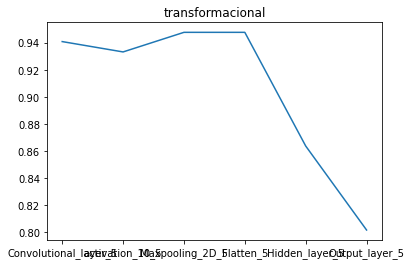

In [21]:
modelo = Modelo(ruta+"/modelosimple.h5")
dataset = Dataset()
iterador = Iterador(modelo,dataset)
#varianza_transformacional = VarianzaTransformacional(iterador,modelo.numero_capas(),modelo.numero_activaciones_por_capa())
#varianza_transformacional.calcular(10,2)
#varianza_muestral = VarianzaMuestral(iterador,modelo.numero_capas(),modelo.numero_activaciones_por_capa())
#varianza_muestral.calcular(10,2)

varianza_normalizada = VarianzaNormalizada(iterador,modelo.numero_capas(),modelo.numero_activaciones_por_capa())
varianza_normalizada.calcular(10,2)

#plt.figure()
#plt.title("transformacional")
#plt.plot(modelo.capas_nombres,varianza_transformacional.varianza_capas)
#print(varianza_transformacional.varianza_capas)

plt.figure()
plt.title("transformacional")
plt.plot(modelo.capas_nombres,varianza_normalizada.varianza_capas)
print(varianza_normalizada.varianza_capas)